<a href="https://colab.research.google.com/github/arunm917/CS6910-Assignment-2/blob/main/CS6910_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
import random
from torchvision.datasets import ImageFolder
from glob import glob
import torchvision.datasets as datasets
from torch.utils.data import ConcatDataset
from torch.utils.data import DataLoader, Subset
import torch.nn as nn

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
classes = ['/Amphibia', '/Animalia', '/Arachnida', '/Aves', '/Fungi', '/Insecta', '/Mammalia', '/Mollusca', '/Plantae', '/Reptilia']

In [23]:
train_dir = '/content/drive/Othercomputers/My Computer/Courses/Deep learning 2023/CS6910-Assignment-2/inaturalist_12K/train'
test_path = '/content/drive/Othercomputers/My Computer/Courses/Deep learning 2023/CS6910-Assignment-2/inaturalist_12K/test'

In [5]:
folders = glob('/content/drive/Othercomputers/My Computer/Courses/Deep learning 2023/CS6910-Assignment-2/inaturalist_12K/train/*')

In [6]:
print(len(folders))

10


#finding mean and std. dev. of the channels of images

In [ ]:
# import os
# import torch
# import torchvision.transforms as transforms
# from PIL import Image

# # Define the path to the folder containing the images
# folder_path = train_path+'/Reptilia'

# # Define the transform to convert images to tensors
# transform = transforms.ToTensor()

# # Create an empty list to store the tensors
# tensor_list = []

# # Loop through each image in the folder and convert it to a tensor
# for filename in os.listdir(folder_path):
#     img_path = os.path.join(folder_path, filename)
#     img = Image.open(img_path)
#     tensor = transform(img)
#     tensor_list.append(tensor)

# # Stack the tensors into a single 4D tensor
# stacked_tensor = torch.stack(tensor_list)

# # Calculate the mean and standard deviation of the stacked tensor
# mean = torch.mean(stacked_tensor, dim=(0, 2, 3))
# std = torch.std(stacked_tensor, dim=(0, 2, 3))

# # Print the calculated mean and standard deviation values
# print("Mean:", mean)
# print("Standard deviation:", std)

# Preprocessing dataset

In [7]:
# Define the image transforms for data augmentation
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [8]:
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [29]:
# Load the dataset
dataset = ImageFolder(train_dir, transform=train_transforms)

In [31]:
#Create a dictionary to store the indices of each class
class_indices = {}
for i, (image, label) in enumerate(dataset):
    if label not in class_indices:
        class_indices[label] = []
    class_indices[label].append(i)

# Split each class into training and validation sets
train_indices = []
val_indices = []
for indices in class_indices.values():
    random.shuffle(indices)
    split = int(0.8 * len(indices))
    train_indices += indices[:split]
    val_indices += indices[split:]

# Create subsets for the training and validation sets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

# Create data loaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [33]:
# Create train, validation and test data loaders
test_dataset = ImageFolder(test_path, transform=test_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

#Data visualization

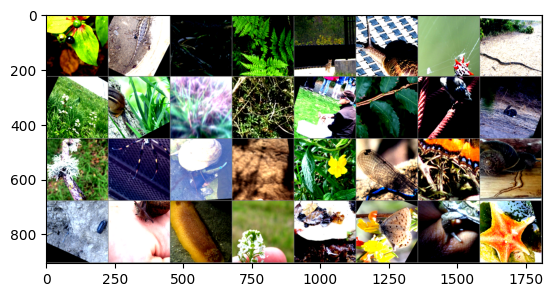

tensor([8, 9, 4, 8, 6, 7, 2, 9, 8, 6, 8, 5, 9, 8, 3, 6, 4, 2, 1, 7, 8, 5, 5, 7,
        1, 7, 7, 8, 4, 5, 0, 1])


In [35]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of images from the train loader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show a few images from the batch
imshow(torchvision.utils.make_grid(images))
print(labels)

# CNN Architecture